In [1]:
import functools
import json
import os
from typing import Any, List, Tuple, Union
import einops
import matplotlib.pyplot as plt
import torch
import torch as t
import torch.nn.functional as F
from fancy_einsum import einsum
from sklearn.linear_model import LinearRegression
from torch import nn
# from toy_transformer import ParenTransformer, SimpleTokenizer
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split

from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm

from torchtyping import TensorType as TT

plt.rcParams.update({'font.size': 22})

MAIN = __name__ == "__main__"
device = "cuda"
IS_CI = os.getenv("IS_CI")

In [2]:
class SimpleTokenizer:

    START_TOKEN = 0
    PAD_TOKEN = 1
    END_TOKEN = 2
    base_d = {"[start]": START_TOKEN, "[pad]": PAD_TOKEN, "[end]": END_TOKEN}

    def __init__(self, alphabet: str):
        self.alphabet = alphabet
        # the 3 is because there are 3 special tokens (defined just above)
        self.t_to_i = {**{c: i + 3 for i, c in enumerate(alphabet)}, **self.base_d}
        self.i_to_t = {i: c for c, i in self.t_to_i.items()}

    def tokenize(self, strs: List[str], max_len = None) -> TT["batch", "seq"]:
        def c_to_int(c: str) -> int:
            if c in self.t_to_i:
                return self.t_to_i[c]
            else:
                raise ValueError(c)

        if isinstance(strs, str):
            strs = [strs]

        if max_len is None:
            max_len = max((max(len(s) for s in strs), 1))

        ints = [
            [self.START_TOKEN] + [c_to_int(c) for c in s] + [self.END_TOKEN] + [self.PAD_TOKEN] * (max_len - len(s))
            for s in strs
        ]
        return t.tensor(ints)

    def decode(self, tokens) -> List[str]:
        assert tokens.ndim >= 2, "Need to have a batch dimension"
        def int_to_c(c: int) -> str:
            if c < len(self.i_to_t):
                return self.i_to_t[c]
            else:
                raise ValueError(c)

        return [
            "".join(int_to_c(i.item()) for i in seq[1:] if i != self.PAD_TOKEN and i != self.END_TOKEN)
            for seq in tokens
        ]

    def __repr__(self) -> str:
        return f"SimpleTokenizer({self.alphabet!r})"

class BracketsDataset:
    """A dataset containing sequences, is_balanced labels, and tokenized sequences"""

    def __init__(self, data_tuples: list):
        """
        data_tuples is List[Tuple[str, bool]] signifying sequence and label
        """
        self.tokenizer = SimpleTokenizer("()")
        self.strs = [x[0] for x in data_tuples]
        self.isbal = t.tensor([x[1] for x in data_tuples])
        self.toks = self.tokenizer.tokenize(self.strs)
        self.open_proportion = t.tensor([s.count("(") / len(s) for s in self.strs])
        self.starts_open = t.tensor([s[0] == "(" for s in self.strs]).bool()

    def __len__(self) -> int:
        return len(self.strs)

    def __getitem__(self, idx) -> Union["BracketsDataset", Tuple[str, t.Tensor, t.Tensor]]:
        if type(idx) == slice:
            return self.__class__(list(zip(self.strs[idx], self.isbal[idx])))
        return (self.strs[idx], self.isbal[idx], self.toks[idx])

    def to(self, device) -> "BracketsDataset":
        self.isbal = self.isbal.to(device)
        self.toks = self.toks.to(device)
        self.open_proportion = self.open_proportion.to(device)
        self.starts_open = self.starts_open.to(device)
        return self

    @property
    def seq_length(self) -> int:
        return self.toks.size(-1)

    @classmethod
    def with_length(cls, data_tuples: List[Tuple[str, bool]], selected_len: int) -> "BracketsDataset":
        return cls([(s, b) for (s, b) in data_tuples if len(s) == selected_len])

    @classmethod
    def with_start_char(cls, data_tuples: List[Tuple[str, bool]], start_char: str) -> "BracketsDataset":
        return cls([(s, b) for (s, b) in data_tuples if s[0] == start_char])

def LN_hook_names(layernorm: LayerNorm) -> Tuple[str, str]:
    '''
    Returns the names of the hooks immediately before and after a given layernorm.
    e.g. LN_hook_names(model.final_ln) returns ["blocks.2.hook_resid_post", "ln_final.hook_normalized"]
    '''
    if layernorm.name == "ln_final":
        input_hook_name = utils.get_act_name("resid_post", 2)
        output_hook_name = "ln_final.hook_normalized"
    else:
        layer, ln = layernorm.name.split(".")[1:]
        input_hook_name = utils.get_act_name("resid_pre" if ln=="ln1" else "resid_mid", layer)
        output_hook_name = utils.get_act_name('normalized', layer, ln)
    
    return input_hook_name, output_hook_name

VOCAB = "()"

cfg = HookedTransformerConfig(
    n_ctx=42,
    d_model=56,
    d_head=28,
    n_heads=2,
    d_mlp=56,
    n_layers=3,
    attention_dir="bidirectional", # defaults to "causal"
    act_fn="relu",
    d_vocab=len(VOCAB)+3, # plus 3 because of end and pad and start token
    d_vocab_out=2, # 2 because we're doing binary classification
    use_attn_result=True, 
    device="cuda",
    use_hook_tokens=True
)

model = HookedTransformer(cfg).eval()

state_dict = t.load("brackets_model_state_dict.pt") #, map_location="cpu")
model.load_state_dict(state_dict)

tokenizer = SimpleTokenizer("()")

def add_perma_hooks_to_mask_pad_tokens(model: HookedTransformer, pad_token: int) -> HookedTransformer:

    # Hook which operates on the tokens, and stores a mask where tokens equal [pad]
    def cache_padding_tokens_mask(tokens: TT["batch", "seq"], hook: HookPoint) -> None:
        hook.ctx["padding_tokens_mask"] = einops.rearrange(tokens == pad_token, "b sK -> b 1 1 sK")

    # Apply masking, by referencing the mask stored in the `hook_tokens` hook context
    def apply_padding_tokens_mask(
        attn_scores: TT["batch", "head", "seq_Q", "seq_K"],
        hook: HookPoint,
    ) -> None:
        attn_scores.masked_fill_(model.hook_dict["hook_tokens"].ctx["padding_tokens_mask"], -1e5)
        if hook.layer() == model.cfg.n_layers - 1:
            del model.hook_dict["hook_tokens"].ctx["padding_tokens_mask"]

    # Add these hooks as permanent hooks (i.e. they aren't removed after functions like run_with_hooks)
    for name, hook in model.hook_dict.items():
        if name == "hook_tokens":
            hook.add_perma_hook(cache_padding_tokens_mask)
        elif name.endswith("attn_scores"):
            hook.add_perma_hook(apply_padding_tokens_mask)

    return model

model.reset_hooks(including_permanent=True)
model = add_perma_hooks_to_mask_pad_tokens(model, tokenizer.PAD_TOKEN)

N_SAMPLES = 10000
with open("brackets_data.json") as f:
    data_tuples: List[Tuple[str, bool]] = json.load(f)
    print(f"loaded {len(data_tuples)} examples")
assert isinstance(data_tuples, list)
data_tuples = data_tuples[:N_SAMPLES]
data = BracketsDataset(data_tuples).to("cuda")
data_mini = BracketsDataset(data_tuples[:100]).to("cuda")

loaded 100000 examples


In [3]:
paren_emb = np.array([-0.22606339, -0.3817214, -1.4104964, 0.19177942, 1.9899428, 0.4391564, 0.7656387, -0.63001657, 1.2170641, -0.78435856, -2.0772018, 0.5796861, 0.14452729, -1.5480461, -1.4717238, 1.3908799, -2.650712, 2.2939675, 1.9186023, 2.2521715, -0.97538763, -2.0912004, -2.1513553, 1.0542943, -1.6433673, -0.49036485, 1.5739079, -1.6167231, 0.005950656, -0.5535703, -1.6153314, 0.34630018, -1.2608914, 2.3687954, -2.0325658, 2.681696, 1.3179133, 0.21228376, 0.2400737, 2.4026039, -0.22275975, -1.6459382, 0.49807006, 0.4056123, 0.574695, 0.31673485, -1.1493986, 1.0393034, 0.48291945, 1.7879814, 0.32313624, -0.44806415, 1.7664179, 1.3369981, 0.039000615, 0.7465193])

In [4]:
is_left = t.sum(data.toks == 3, dim=1)
is_right = t.sum(data.toks == 4, dim=1)
equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()

In [5]:
out, cache = model.run_with_cache(data.toks)

In [6]:
strs = ["()))(" + "(" * (i+1) + ")" * i for i in range(1, 10)]
test_data = tokenizer.tokenize(strs)
results, test_cache = model.run_with_cache(test_data)
results = results[:, 0]
print(results)

tensor([[ 5.7767, -5.9165],
        [ 5.7278, -5.8643],
        [ 5.5289, -5.6792],
        [ 5.3236, -5.4965],
        [ 5.3217, -5.5018],
        [ 5.2945, -5.4799],
        [ 5.3380, -5.5165],
        [ 5.5408, -5.6960],
        [ 5.4463, -5.5929]], device='cuda:0', grad_fn=<SelectBackward0>)


In [7]:
from functools import partial

model.reset_hooks()

def intervene(value, hook, intervention0, intervention1):

    value[:, 5] += intervention0
    value[:, 6] += intervention1

    return value

low = -0.5
high = 0.05
scalings = np.arange(low, high, 0.01)

preds = []

for i in scalings:

    preds.append([])

    for j in scalings:

        intervention0 = t.tensor(paren_emb * i, device=device)
        intervention1 = t.tensor(paren_emb * j, device=device)
        interv_func = partial(intervene, intervention0=intervention0, intervention1=intervention1)
        out = model.run_with_hooks(test_data, fwd_hooks=[
            ("blocks.0.hook_attn_out", interv_func)
        ])

        pred_valid = t.softmax(out[:, 0], dim=-1)[:, 1]
        preds[-1].append(pred_valid.detach().cpu().numpy())

preds = np.array(preds)

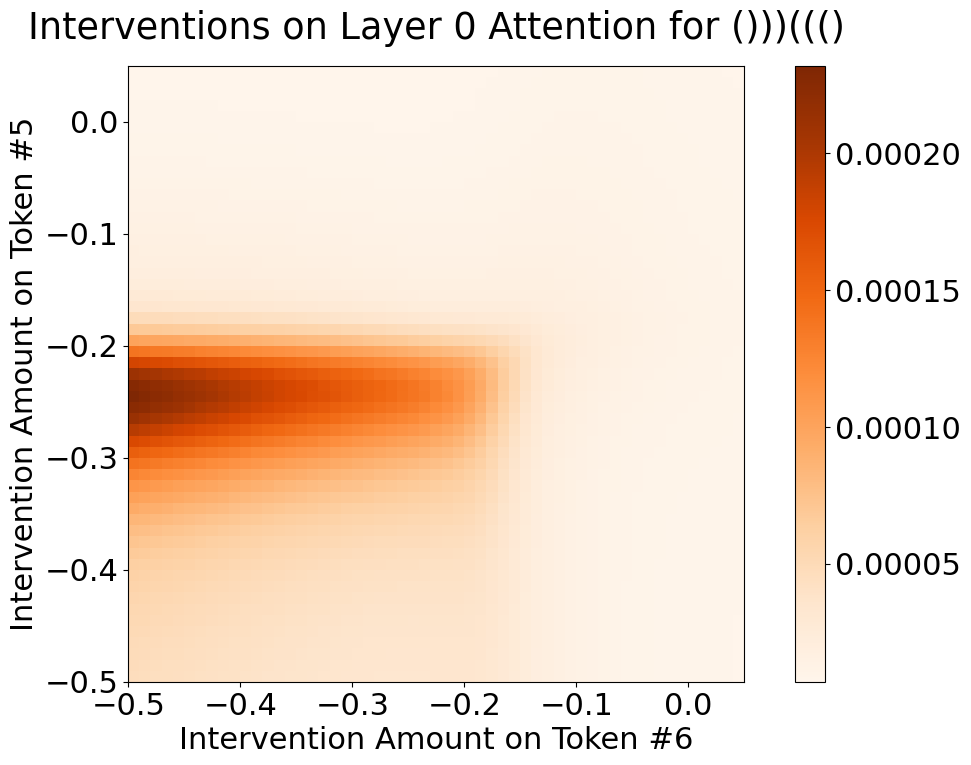

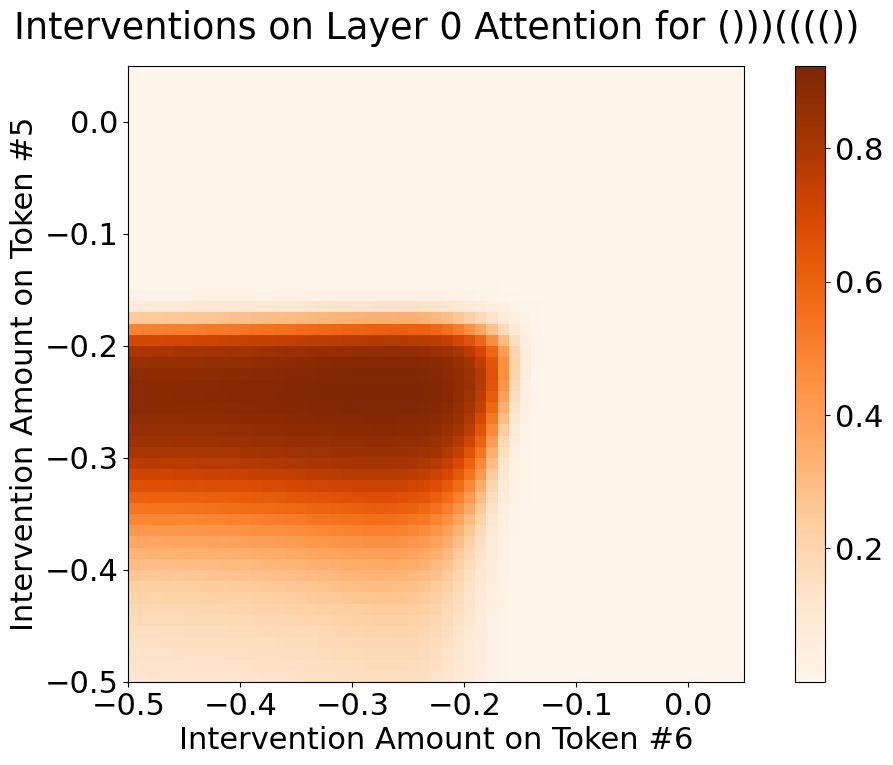

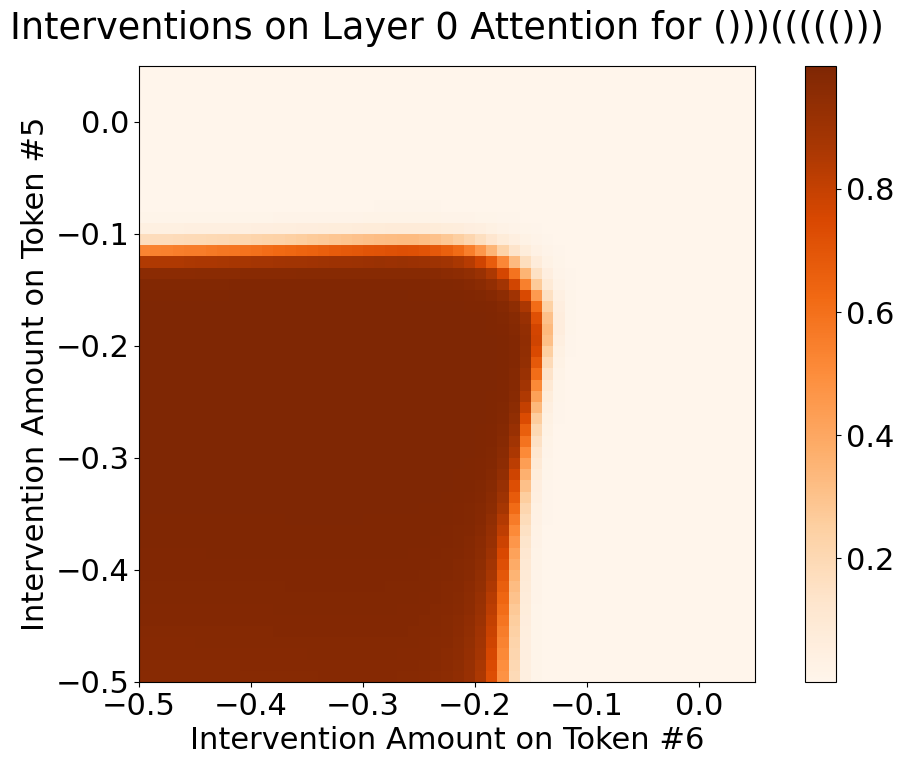

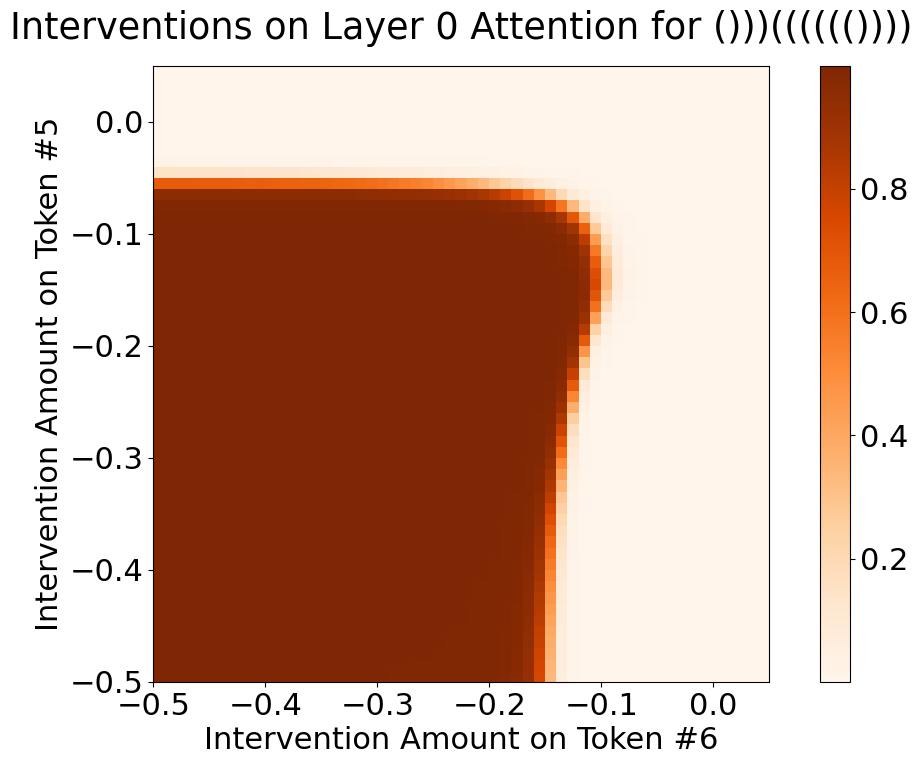

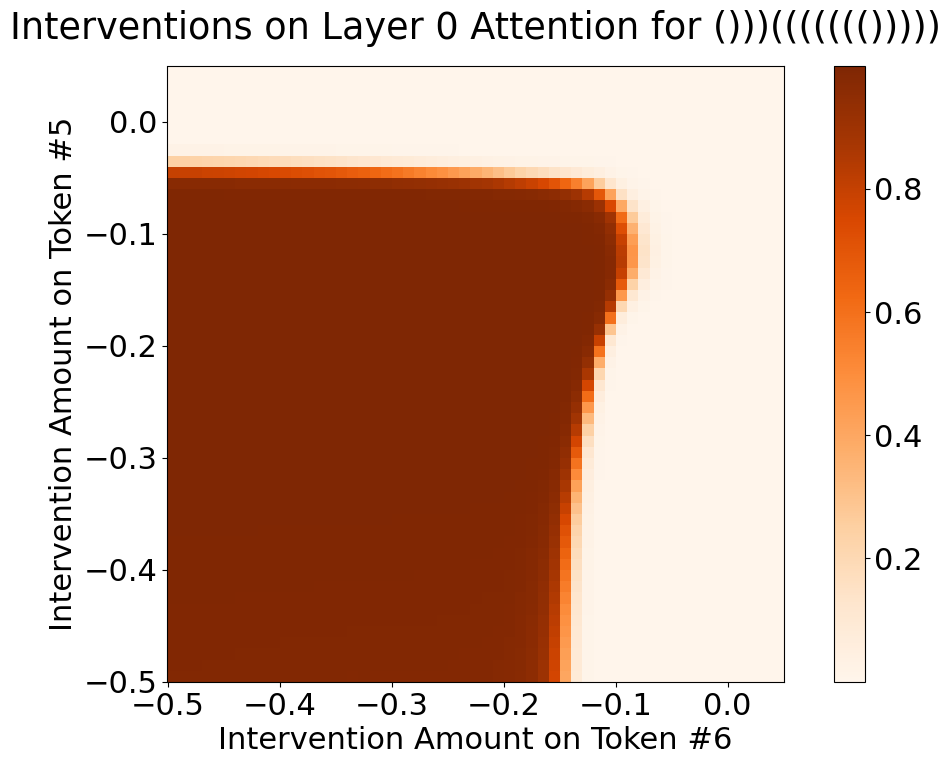

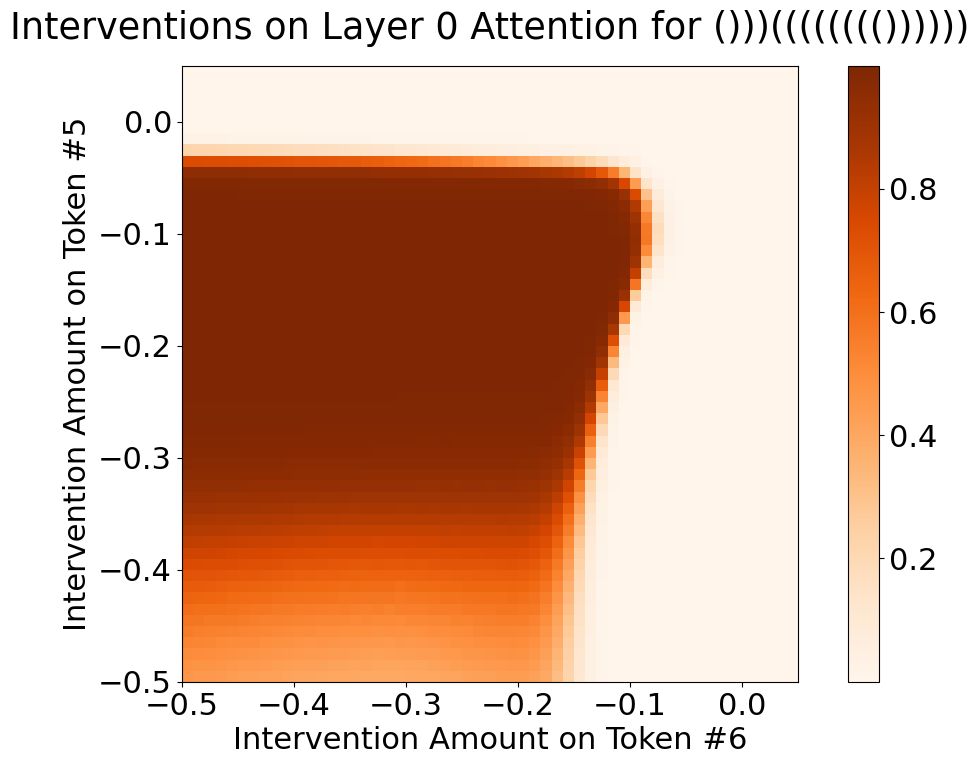

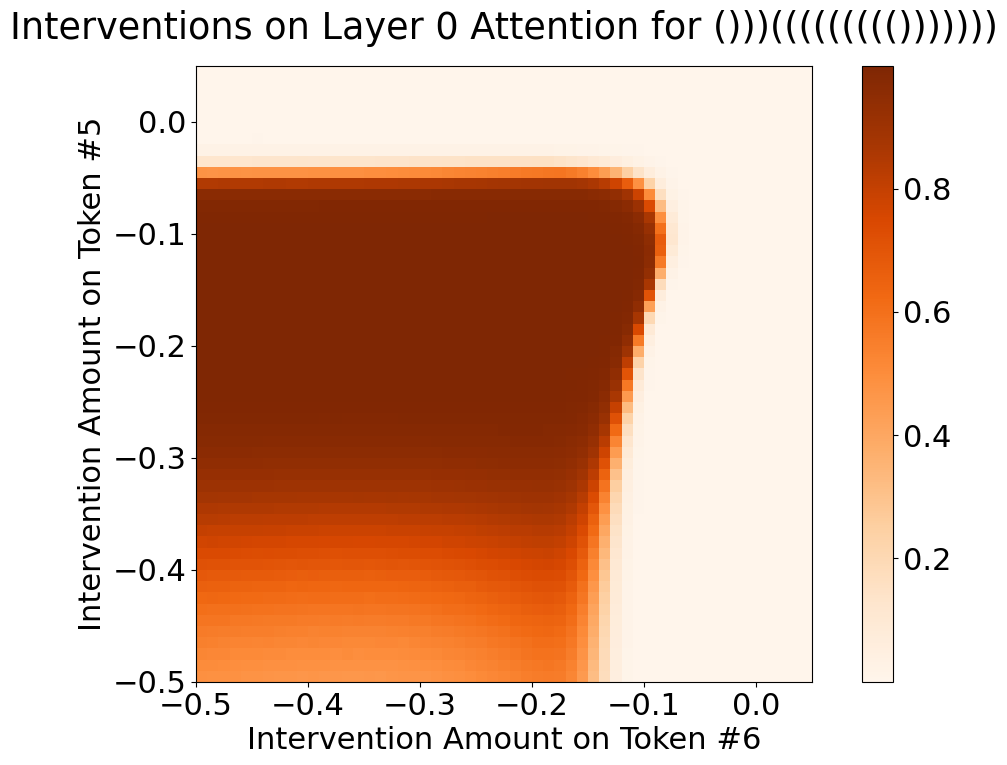

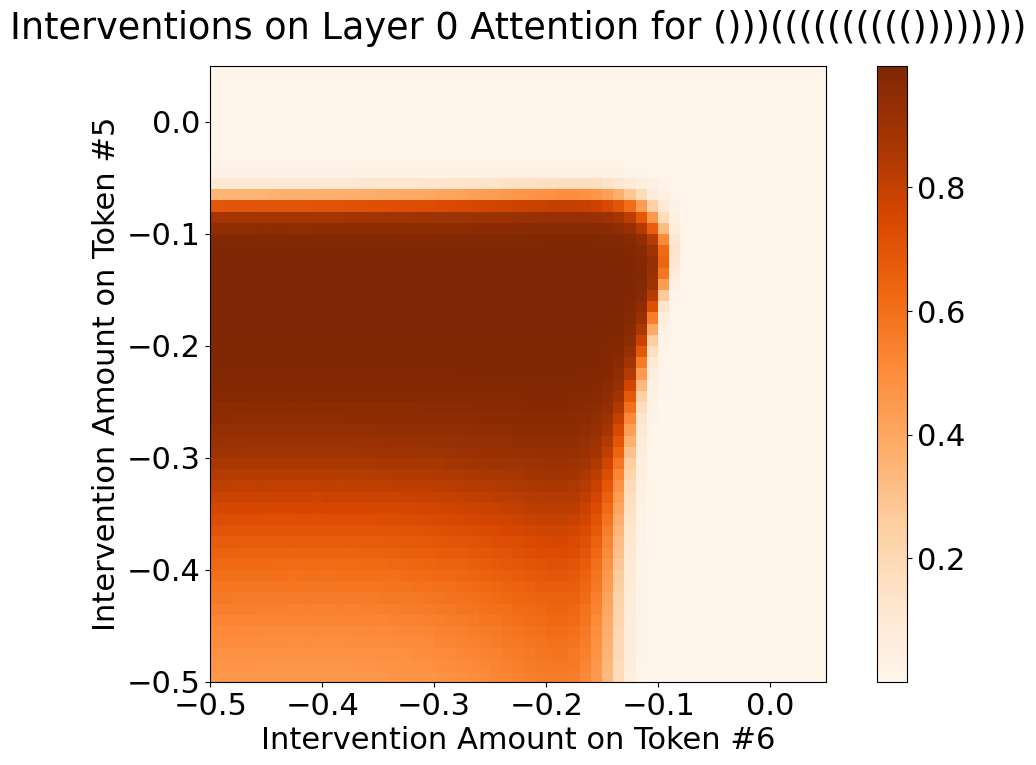

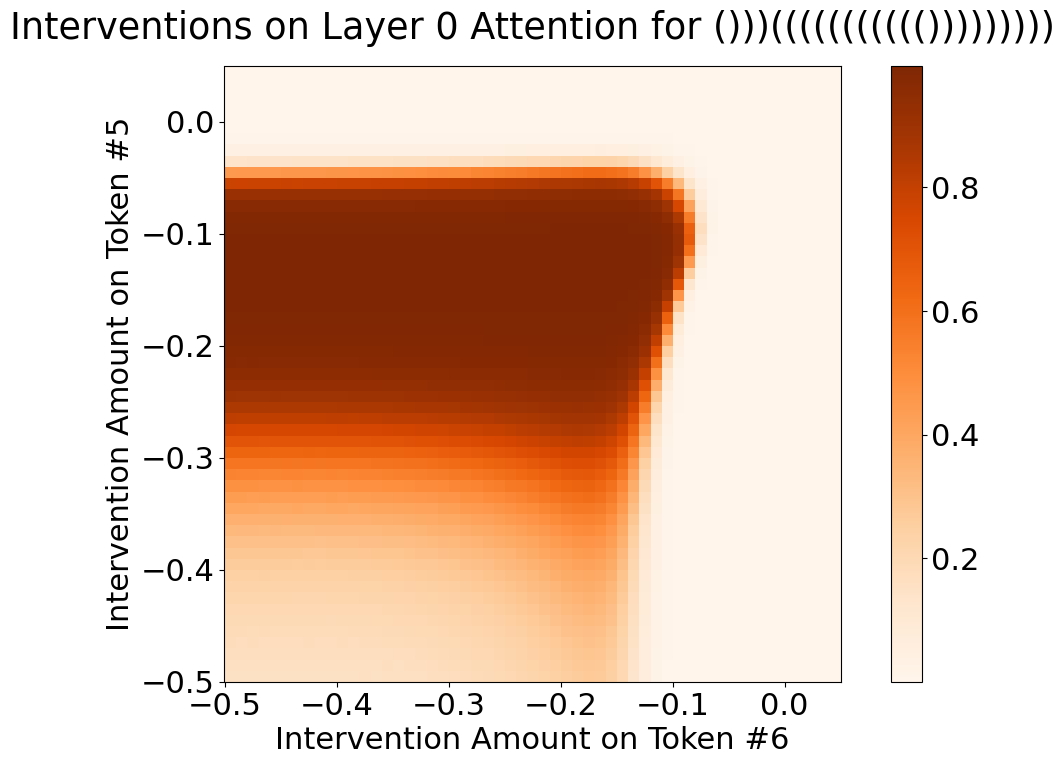

In [8]:
for index in range(len(strs)):
    plt.figure(figsize=(13, 8))
    plt.imshow(preds[:, :, index], cmap="Oranges", extent=[low, high, low, high], origin='lower')
    plt.colorbar()
    plt.ylabel("Intervention Amount on Token #5")
    plt.xlabel("Intervention Amount on Token #6")
    plt.title(f"Interventions on Layer 0 Attention for {strs[index]}", y=1.03)

In [9]:
layer = "blocks.0.hook_mlp_out"

from sklearn.model_selection import train_test_split
from torch import nn

probe = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(56, 1)
)
probe.to(device)

i = 4

j = 4

mlp_vectors = cache[layer].cpu().numpy()[:, j]

is_left = t.sum(data.toks[:, j:] == 3, dim=1)
is_right = t.sum(data.toks[:, j:] == 4, dim=1)
mask = (is_left + is_right >= 4).cpu().numpy()
equal = (is_left > is_right).cpu().numpy()

mlp_vectors_train, mlp_vectors_test, equal_train, equal_test = train_test_split(mlp_vectors[mask], equal[mask])
mlp_vectors_train = t.tensor(mlp_vectors_train, requires_grad=False, device=device)
equal_train = t.tensor(equal_train, requires_grad=False, device=device).unsqueeze(1) * 1.
mlp_vectors_test = t.tensor(mlp_vectors_test, requires_grad=False, device=device)
equal_test = t.tensor(equal_test, requires_grad=False, device=device).unsqueeze(1) * 1.

loss = nn.BCEWithLogitsLoss()

opt = t.optim.Adam(probe.parameters(), lr=0.1)
for epoch in range(20000):
    opt.zero_grad()
    preds = probe(mlp_vectors_train)

    l = loss(preds, equal_train)
    l.backward()
    opt.step()

    if epoch % 2000 == 0:
        with t.no_grad():
            preds_test = probe(mlp_vectors_test)
            l_test = loss(preds_test, equal_test)
            print("TRAIN LOSS:", l.item())
            print("TEST LOSS:", l_test.item())

            num_correct_test = t.sum((preds_test > 0) == equal_test)

            print("TEST ACC:", num_correct_test.item() / len(equal_test))

TRAIN LOSS: 0.7667862176895142
TEST LOSS: 0.5285510420799255
TEST ACC: 0.8454047474132684
TRAIN LOSS: 0.18748387694358826
TEST LOSS: 0.1805049031972885
TEST ACC: 0.9300060864272672
TRAIN LOSS: 0.18971583247184753
TEST LOSS: 0.18453148007392883
TEST ACC: 0.928180158247109
TRAIN LOSS: 0.1882179230451584
TEST LOSS: 0.1752246767282486
TEST ACC: 0.9391357273280584
TRAIN LOSS: 0.19065183401107788
TEST LOSS: 0.17927545309066772
TEST ACC: 0.9306147291539866
TRAIN LOSS: 0.18955309689044952
TEST LOSS: 0.17747919261455536
TEST ACC: 0.9348752282410225
TRAIN LOSS: 0.18623480200767517
TEST LOSS: 0.1835400015115738
TEST ACC: 0.9324406573341448
TRAIN LOSS: 0.185787633061409
TEST LOSS: 0.18025213479995728
TEST ACC: 0.9373097991479001
TRAIN LOSS: 0.18898814916610718
TEST LOSS: 0.18561199307441711
TEST ACC: 0.9354838709677419
TRAIN LOSS: 0.18605946004390717
TEST LOSS: 0.18127836287021637
TEST ACC: 0.9318320146074255


In [112]:
probe.eval()
preds_test = probe(mlp_vectors_test)
num_correct_test = t.sum((preds_test > 0) == equal_test)
print("TEST ACC:", num_correct_test.item() / len(equal_test))

TEST ACC: 0.9452221545952526


In [10]:
strs = ["())" + "(" * (i+1) + ")" * i for i in range(1, 10)]
test_data = tokenizer.tokenize(strs)
results, test_cache = model.run_with_cache(test_data)
results = results[:, 0]
print(results)

tensor([[ 5.1148, -5.1910],
        [ 4.7832, -4.8359],
        [ 4.6516, -4.6995],
        [ 4.5786, -4.6390],
        [ 4.8004, -4.8949],
        [ 4.9147, -5.0277],
        [ 4.8870, -5.0076],
        [ 4.9918, -5.1129],
        [ 5.1280, -5.2430]], device='cuda:0', grad_fn=<SelectBackward0>)


/tmp/ipykernel_114669/1067507468.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intervention = t.tensor(edit_dir * i, device=device)


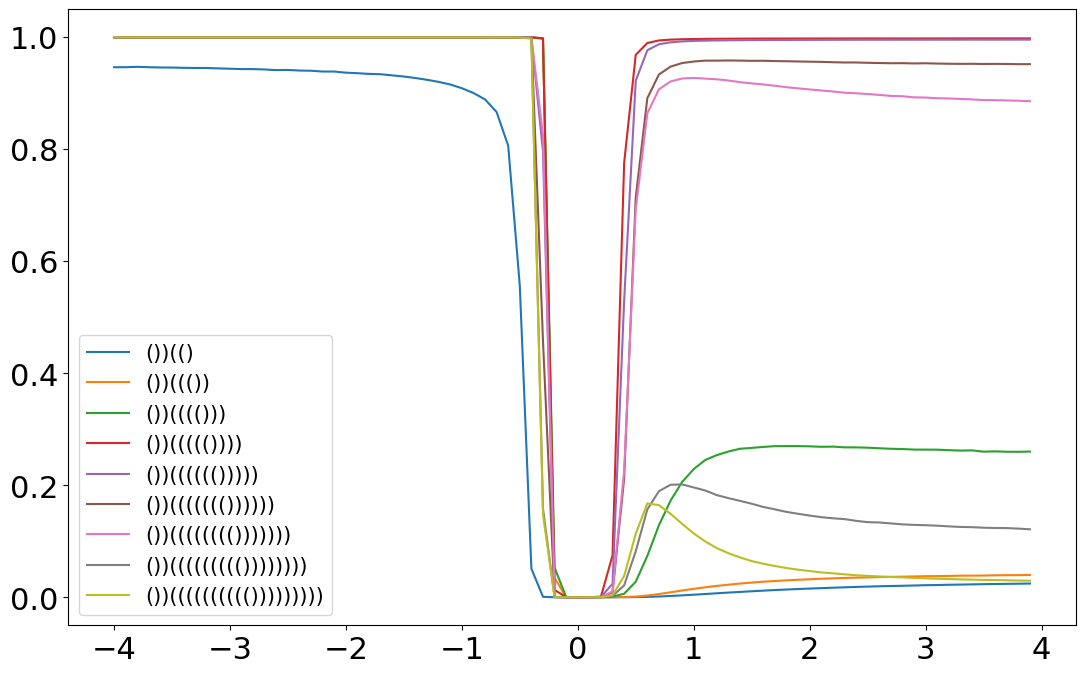

In [11]:
edit_dir = probe[1].weight
# edit_dir = paren_emb

from functools import partial

model.reset_hooks()

def intervene(value, hook, intervention):
    
    value[:, 4] += intervention

    return value

low = -4
high = 4
scalings = np.arange(low, high, 0.1)

preds = []

for i in scalings:

    intervention = t.tensor(edit_dir * i, device=device)
    interv_func = partial(intervene, intervention=intervention)
    out = model.run_with_hooks(test_data, fwd_hooks=[
        (layer, interv_func)
    ])

    pred_valid = t.softmax(out[:, 0], dim=-1)[:, 1]
    preds.append(pred_valid.detach().cpu().numpy())

preds = np.array(preds)

plt.figure(figsize=(13, 8))
preds = np.array(preds)
objs = plt.plot(scalings, preds)
plt.legend(objs, strs, fontsize=15)

In [13]:
strs = ["(" * i + ")" * (i*2) for i in range(1, 10)]
test_data = tokenizer.tokenize(strs)
results, test_cache = model.run_with_cache(test_data)
results = results[:, 0]
print(results)

tensor([[ 4.7732, -4.8305],
        [ 4.9097, -4.9761],
        [ 4.8381, -4.9114],
        [ 4.8744, -4.9581],
        [ 4.8637, -4.9554],
        [ 4.8661, -4.9635],
        [ 4.8539, -4.9512],
        [ 4.8379, -4.9386],
        [ 4.8185, -4.9265]], device='cuda:0', grad_fn=<SelectBackward0>)


In [14]:
# INTERVENING ON NET UNBALANCED SEQUENCES
from functools import partial

model.reset_hooks()

def intervene(value, hook, intervention0, intervention1):
    
    value[:, 0] += intervention0
    value[:, 1] += intervention1

    return value

scalings = np.arange(0, 1, 0.1)

preds = []

for i in scalings:

    preds.append([])

    for j in scalings:

        intervention0 = t.tensor(paren_emb * i, device=device)
        intervention1 = t.tensor(paren_emb * j, device=device)
        interv_func = partial(intervene, intervention0=intervention0, intervention1=intervention1)
        out = model.run_with_hooks(test_data, fwd_hooks=[
            ("blocks.0.hook_attn_out", interv_func)
        ])

        pred_valid = t.softmax(out[:, 0], dim=-1)[:, 1]
        preds[-1].append(pred_valid.detach().cpu().numpy())

preds = np.array(preds)

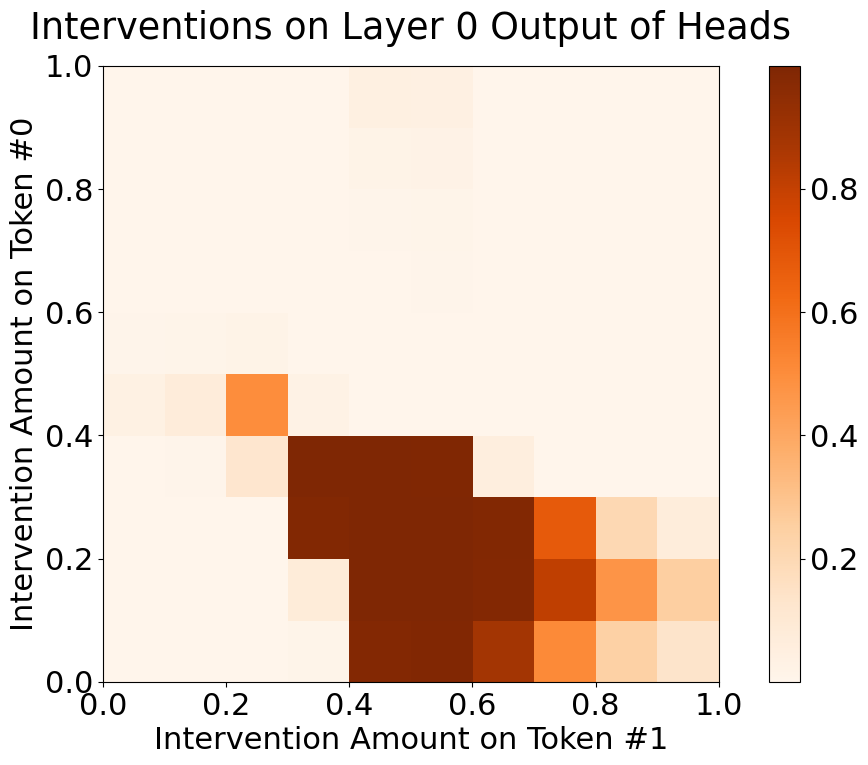

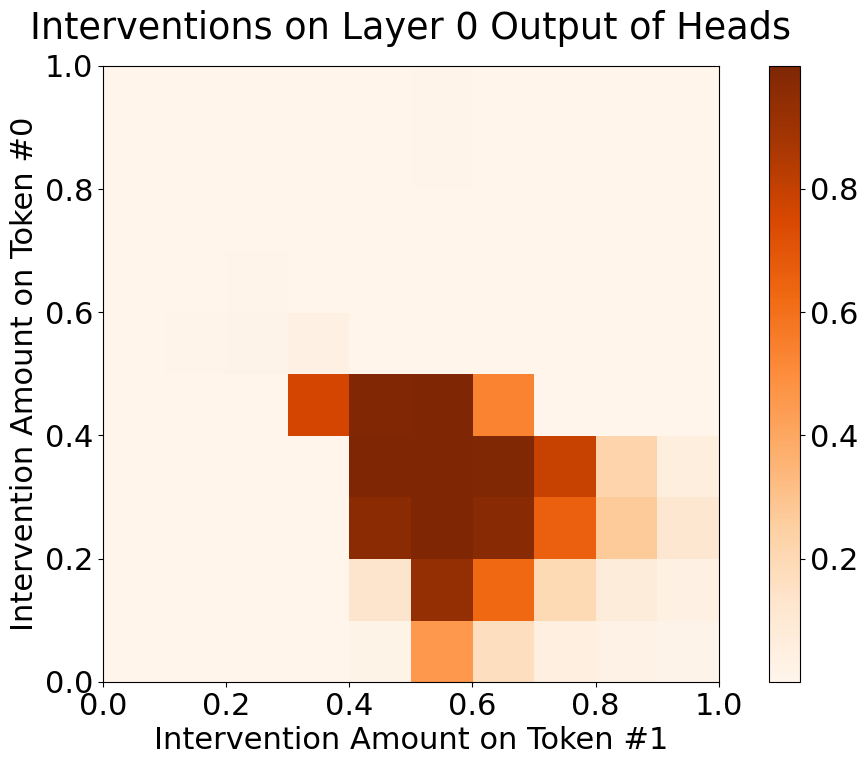

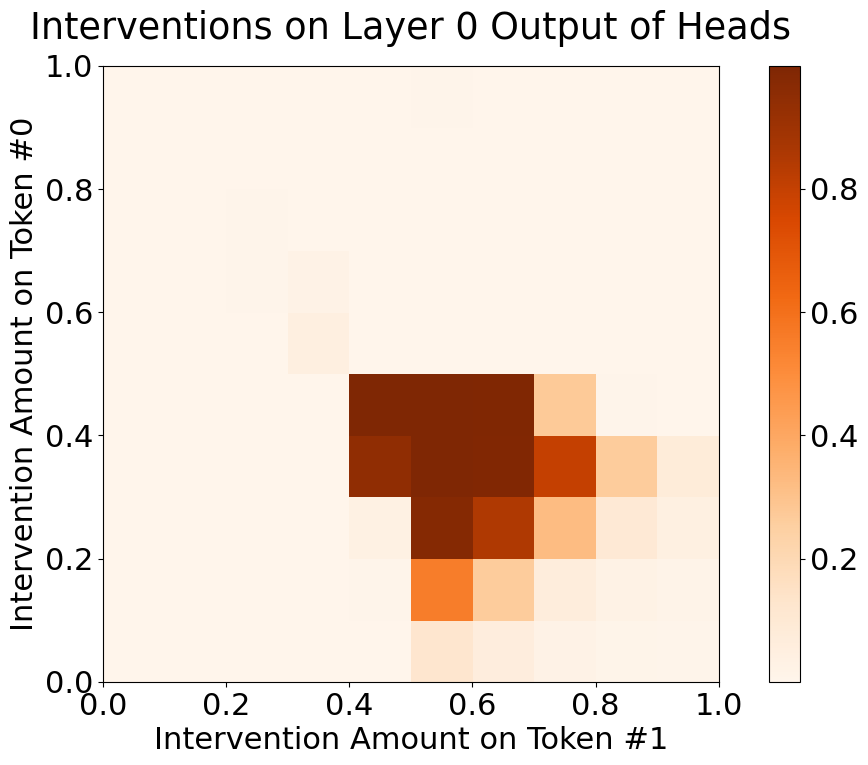

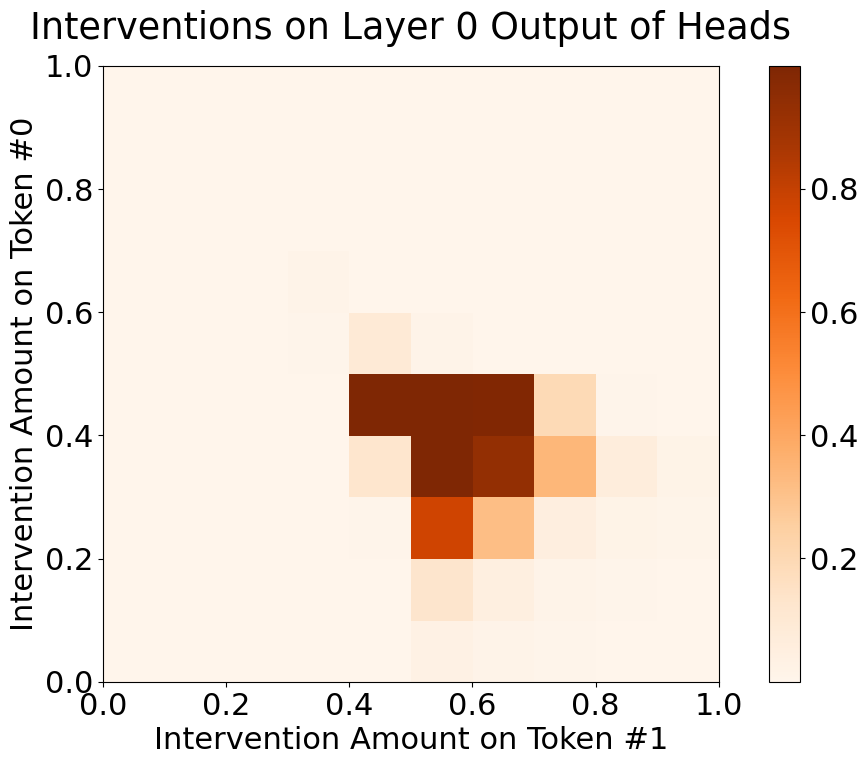

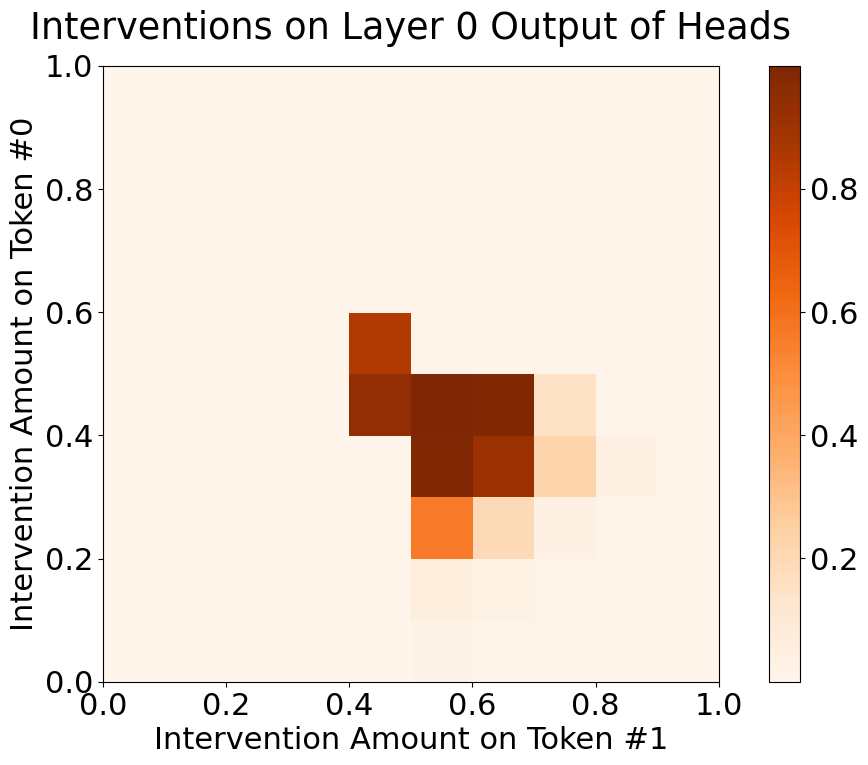

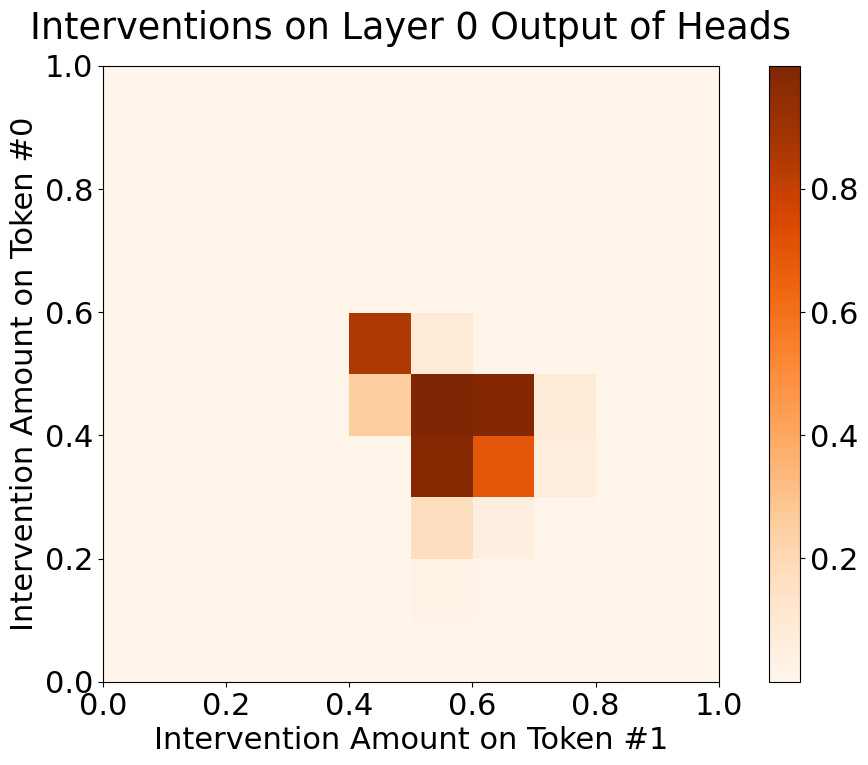

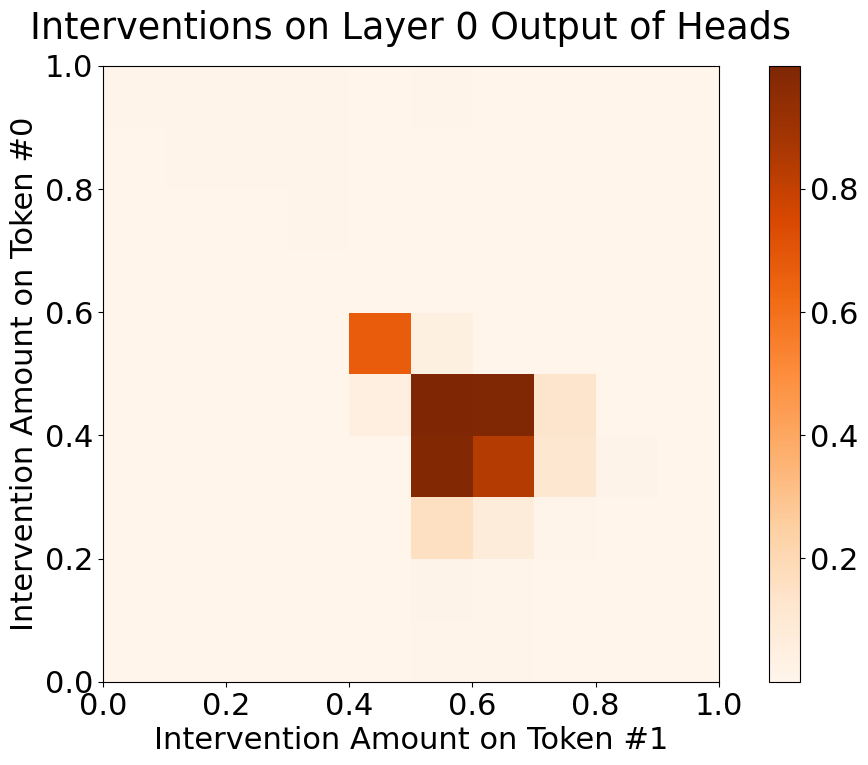

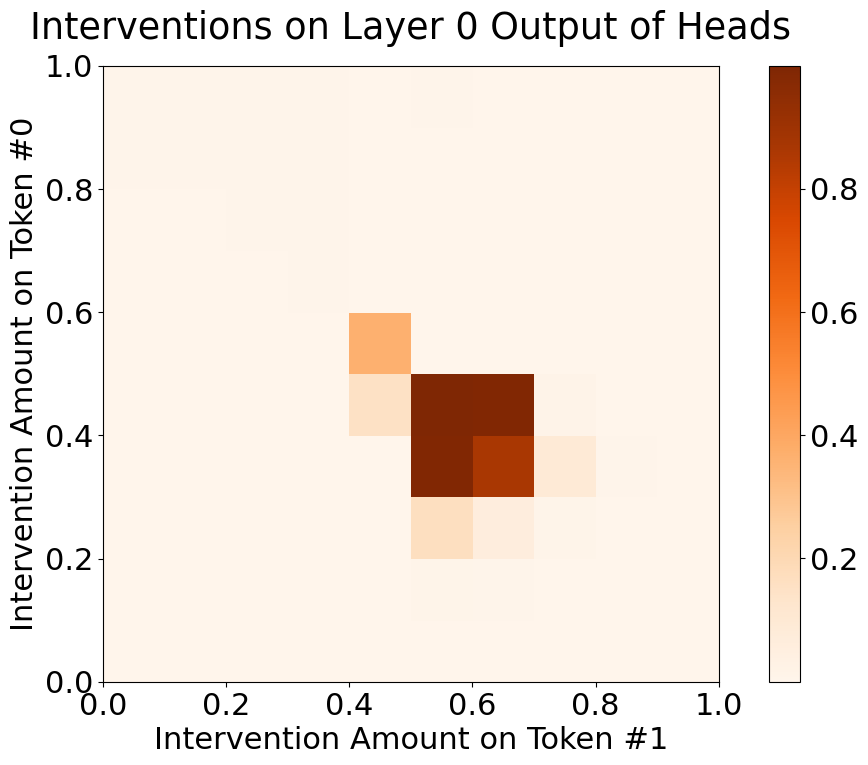

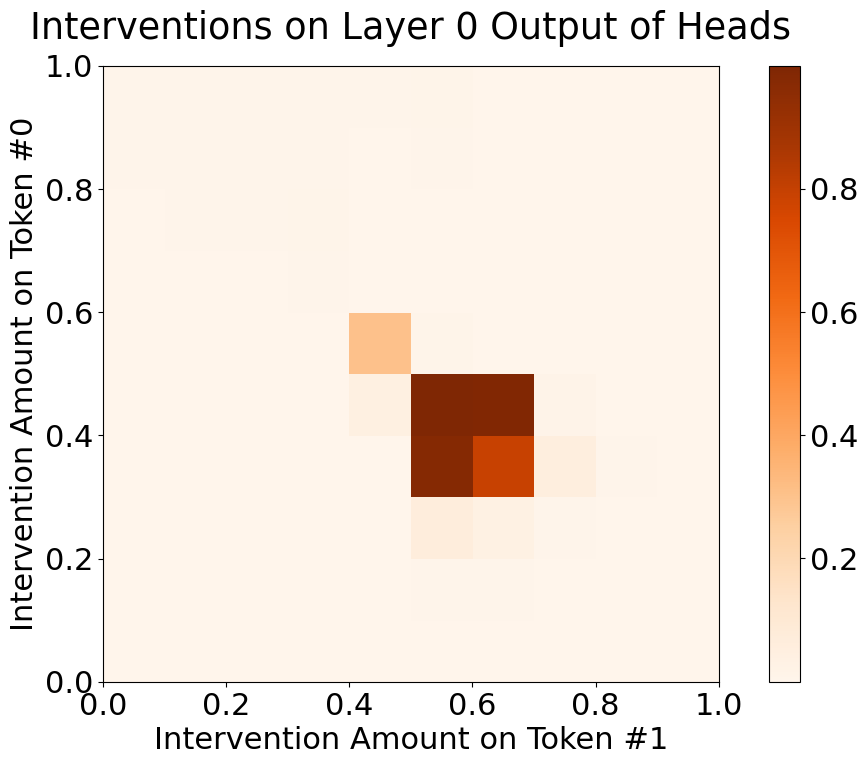

In [18]:
for i in range(preds.shape[2]):
    plt.figure(figsize=(13, 8))
    plt.imshow(preds[:, :, i], cmap="Oranges", extent=[0, 1, 0, 1], origin='lower')
    plt.colorbar()
    plt.ylabel("Intervention Amount on Token #0")
    plt.xlabel("Intervention Amount on Token #1")
    plt.title("Interventions on Layer 0 Output of Heads", y=1.03)

Text(0.5, 1.0, 'Intervention scores w/ scaling on Token #0 = 0.3')

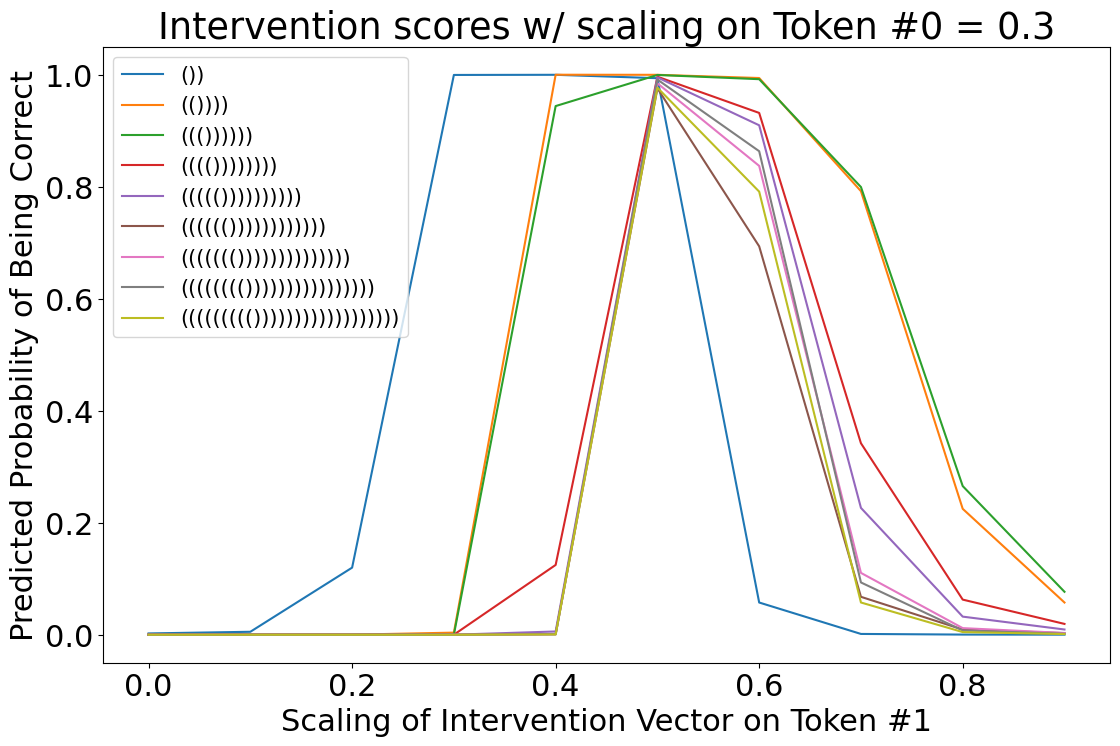

In [21]:
i = 3
plt.figure(figsize=(13, 8))
objs = plt.plot(scalings, preds[i])
plt.legend(objs, strs, fontsize=15)
plt.xlabel("Scaling of Intervention Vector on Token #1")
plt.ylabel("Predicted Probability of Being Correct")
plt.title(f"Intervention scores w/ scaling on Token #0 = 0.3")